In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
import kagglehub
import os

path_dataset_kaggle = kagglehub.dataset_download("anairamcosta/water-potability-csv")
path_df = os.path.join(path_dataset_kaggle, "water_potability.csv")
df_water = pd.read_csv(path_df)
print(df_water.head())
print(df_water.shape)

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
(3276, 10)


Descripcion de las variables
- *1 miligramo de sulfato por litro de agua (mg/L) <> ppm

* **ph**: pH del agua (rango: 0 a 14).
* **Hardness**: Medida de los minerales presentes en el agua.
* **Solids**: Total de sólidos disueltos en ppm.
* **Chloramines**: Cantidad de cloraminas en ppm.
* **Sulfate**: Cantidad de sulfatos disueltos en el agua en ppm.
* **Conductivity**: Conductividad eléctrica del agua en μS/cm.
* **Organic_carbon**: Cantidad de carbono orgánico en ppm.
* **Trihalomethanes**: Cantidad de trihalometanos en μg/L.
* **Turbidity**: Medida de las propiedades de dispersión de la luz1 del agua en NTU. 
* **Potability**: Indica si el agua es potable (1) o no (0).

In [105]:
# verificando los valores nulos presentes
df_water.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Imputación de datos faltantes

In [106]:
from sklearn.impute import KNNImputer

knn_impute = KNNImputer(n_neighbors=3)
df_water_imputer = knn_impute.fit_transform(df_water)
df_water_imputer = pd.DataFrame(df_water_imputer, columns=df_water.columns)
print(df_water_imputer.head())

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  6.655223  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  351.285226    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  347.323743    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135         0.0  
1       15.180013        56.329076   4.500656         0.0  
2       16.868637        66.420093   3.055934         0.0  
3       18.436524       100.341674   4.628771         0.0  
4       11.558279        31.997993   4.075075         0.0  


In [107]:
df_water_imputer.Potability.value_counts()

Potability
0.0    1998
1.0    1278
Name: count, dtype: int64

In [108]:
df_water.Potability.value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

Balanceando los valores de la variable dependiente

In [109]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(df_water_imputer.drop("Potability", axis=1), df_water[["Potability"]])
np.unique(y_ros, return_counts=True)

(array([0, 1]), array([1998, 1998]))

Normalizando las variables independientes

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# separando las variables independientes y dependiente
X = X_ros
y = y_ros

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [111]:
X_train.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

In [112]:
y_test.value_counts()

Potability
1             406
0             394
Name: count, dtype: int64

## Creando el modelo de red neuronal

In [113]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, Input #type: ignore
from tensorflow.keras import regularizers #type: ignore
from tensorflow.keras.optimizers import Adam #type:ignore

model_rn = Sequential()
model_rn.add(Input((9,)))
model_rn.add(Dense(units=5, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_rn.add(Dropout(0.5))
model_rn.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_rn.add(Dropout(0.5))
model_rn.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_rn.add(Dropout(0.5))
model_rn.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_rn.add(Dropout(0.5))
model_rn.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_rn.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model_rn.add(Dense(units=1, activation='sigmoid'))

model_rn.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 5)              │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

Compilando el modelo

In [114]:
model_rn.compile(optimizer=Adam(learning_rate=0.001),
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

Entrenamiento del modelo

In [115]:
history = model_rn.fit(X_train, y_train, batch_size=50, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5244 - loss: 783.4979 - val_accuracy: 0.4925 - val_loss: 94.6603
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4944 - loss: 226.6980 - val_accuracy: 0.4925 - val_loss: 68.9193
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4894 - loss: 125.5928 - val_accuracy: 0.4925 - val_loss: 11.9820
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4953 - loss: 64.5559 - val_accuracy: 0.5075 - val_loss: 4.4410
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5078 - loss: 44.6154 - val_accuracy: 0.5075 - val_loss: 7.2950
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5075 - loss: 37.5562 - val_accuracy: 0.5075 - val_loss: 10.3727
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5056 - loss: 28.3011 - val_accuracy: 0.5075 - val_loss: 11.2166
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5047 - loss: 21.1044 - val_accuracy: 0

In [116]:
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['accuracy']
val_presc = history.history['val_accuracy']
epocas = range(1, len(loss) + 1)

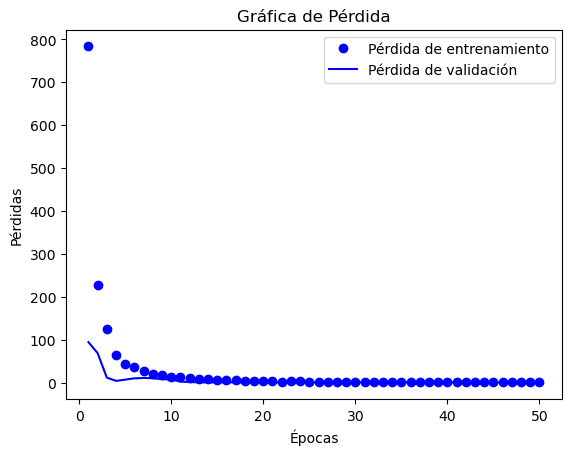

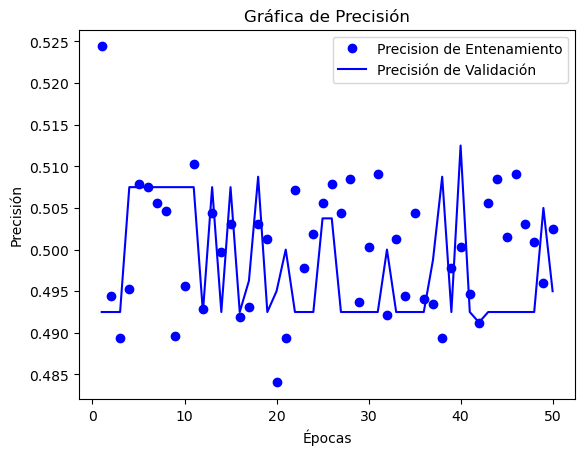

In [117]:
plt.plot(epocas, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epocas, val_loss, 'b', label='Pérdida de validación')
plt.title('Gráfica de Pérdida')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Pérdidas')
plt.show()

plt.plot(epocas, precision, 'bo', label='Precision de Entenamiento')
plt.plot(epocas, val_presc, 'b', label='Precisión de Validación')
plt.title('Gráfica de Precisión')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.show()